# Chicago crime dataset analysis
---

In this notebook,We are using Spark, Pandas, Matplotlib, Seaborn to predict the crime type based on other variables.

. The point is:

 * Perform data reading, transforming, and querying using Apache Spark
 * Visualize using existing Python libraries. Matplotlib will remain when I know to do with it all that I'm currenly using Seaborn for.
 * Where interoperation between Spark and Matplotlib is a hindrance, I use Pandas and Numpy.
 * MLlib Library
 * SparkQL

---

## Get Imports out of the way



Spark imports

In [1]:
## spark imports
from pyspark.sql import Row, SparkSession
import pyspark.sql.functions as F

Standard python data analysis imports

In [2]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Jupyter visualization options

In [3]:
%matplotlib inline

#Not too sure the following 2 work. This is a TODO
sns.set_color_codes("pastel")
plt.rcParams["figure.figsize"] = [20, 8]

In [4]:
# Import PySpark
import pyspark
from pyspark.sql import SparkSession

#Create SparkSession
spark = SparkSession.builder.getOrCreate()
#conf = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'),('spark.driver.memory','8g')])

#sc = pyspark.SparkContext(conf=conf)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/11 00:03:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/11 00:03:27 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


---
## Dataset information

First, clean the headers. This is just for nice presentation of headers. Having valid data frame field names that conform to Python identifier rules is good. I personally prefer that as it's always helpful to use the dot notation in many places.

These are the column names, as pulled from the Kaggle dataset page [here](https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis)

In [5]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [6]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

Turn a list of headers to a list of dictionaries produced by the above function

In [7]:
header_dics = list(map(entry_dic, list(__builtin__.filter(lambda l: l != '', content_cols.split('\n')))))

In [8]:
header_dics[:4]

[{'title': 'ID',
  'description': 'Unique identifier for the record.',
  'header': 'id'},
 {'title': 'Case Number',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number'},
 {'title': 'Date',
  'description': 'Date when the incident occurred. this is sometimes a best estimate.',
  'header': 'date'},
 {'title': 'Block',
  'description': 'The partially redacted address where the incident occurred, placing it on the same block as the actual address.',
  'header': 'block'}]

---
## Reading the data

Using the Spark's csv reader to parse the files. It processes multiple files and returns a single data frame:

In [9]:
df = spark.read.csv('pre_processed_data/part-00000-982055db-94e8-4dc0-92a4-5536b6b1485b-c000.csv', inferSchema=True, header=True)

In [10]:
# Caching this data frame as it's going to be read over and over again
df = df.cache()

In [11]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



---
**Rename columns so that we can use the dot notation**

In [12]:
for h in header_dics:
    df = df.withColumnRenamed(h['title'], h['header'])
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



Taking an initial look at the content of the data frame:

In [13]:
df.show(n=3, truncate=False)

+----------------------+-------------------+------------+--------------------+------+----+--------+----+--------------+----+------------+-------------+-----+-------+
|date                  |block              |primary_type|location_description|arrest|beat|district|ward|community_area|year|latitude    |longitude    |Month|WeekDay|
+----------------------+-------------------+------------+--------------------+------+----+--------+----+--------------+----+------------+-------------+-----+-------+
|09/05/2015 01:30:00 PM|043XX S WOOD ST    |BATTERY     |RESIDENCE           |false |924 |9       |12  |61            |2015|41.815117282|-87.669999562|9    |7      |
|09/04/2015 11:30:00 AM|008XX N CENTRAL AVE|THEFT       |CTA BUS             |false |1511|15      |29  |25            |2015|41.895080471|-87.765400451|9    |6      |
|09/05/2015 12:45:00 PM|035XX W BARRY AVE  |NARCOTICS   |SIDEWALK            |true  |1412|14      |35  |21            |2015|41.937405765|-87.716649687|9    |7      |
+---

---
## Looking at the data

In [14]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [15]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

Total record count:

In [16]:
print(df.count())

3410511


How many features do we have

In [17]:
Untitled Folderdf.columns

['date',
 'block',
 'primary_type',
 'location_description',
 'arrest',
 'beat',
 'district',
 'ward',
 'community_area',
 'year',
 'latitude',
 'longitude',
 'Month',
 'WeekDay']

In [18]:
#Let's see the schema of the data frame:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- ward: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- WeekDay: integer (nullable = true)



### Crime types

These are the top 20 most frequent crime types:

I like doing some things by hand, but it's clear that here, one can obtain a Pandas data frame by calling:

``
crime_type_counts.toPandas()
``

In [19]:
counts_pddf = pd.DataFrame(crime_type_counts.rdd.map(lambda l: l.asDict()).collect())

In [20]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,768276
1,BATTERY,624250
2,CRIMINAL DAMAGE,372078
3,NARCOTICS,263725
4,ASSAULT,237356
5,OTHER OFFENSE,210481
6,BURGLARY,185492
7,DECEPTIVE PRACTICE,180702
8,MOTOR VEHICLE THEFT,166431
9,ROBBERY,133054


[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

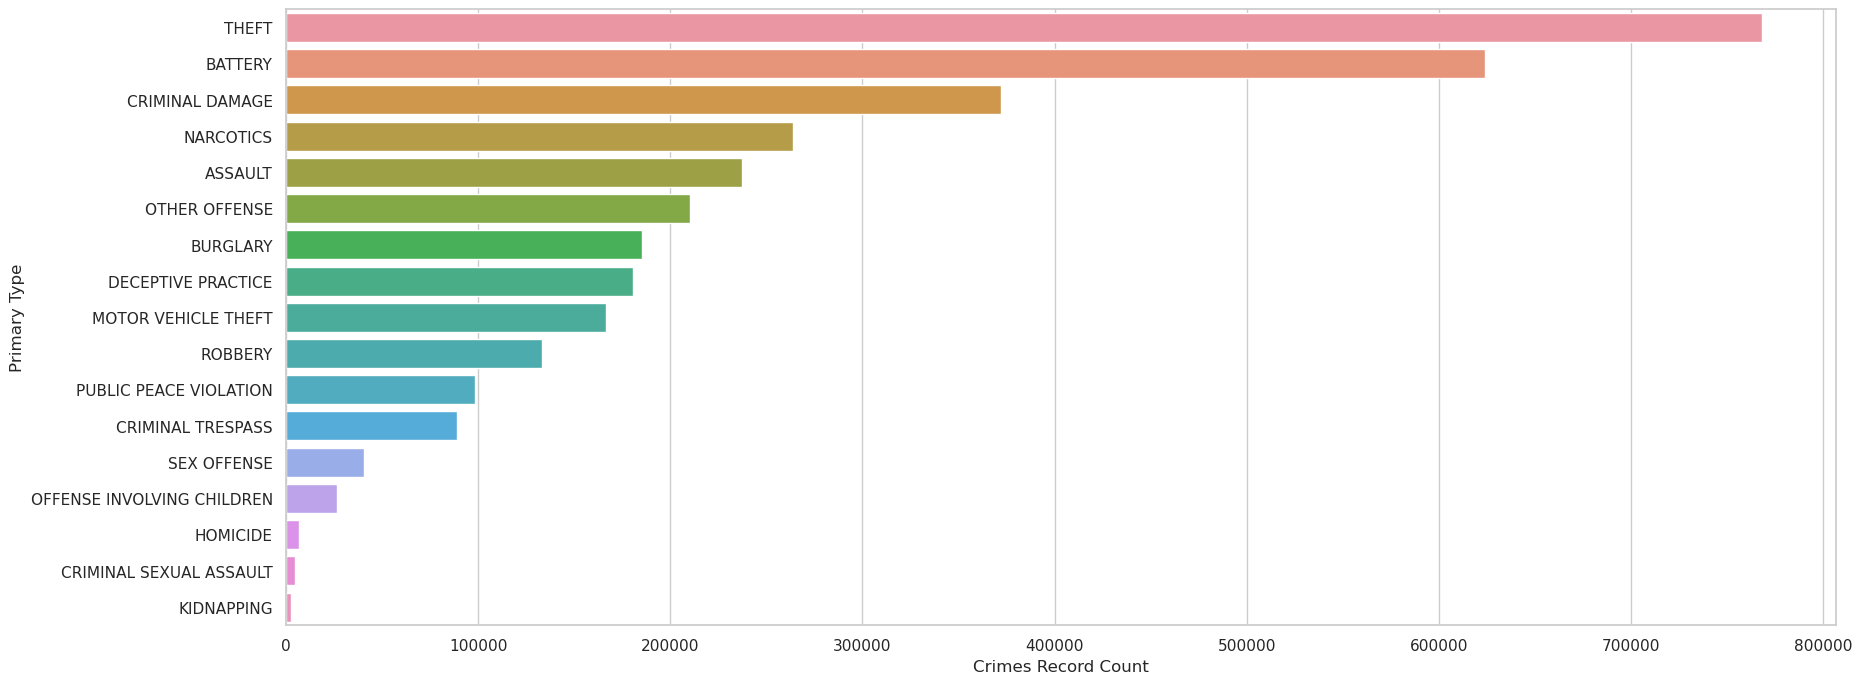

In [21]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

### Recorded Date

In [22]:
import datetime
from pyspark.sql.functions import *

In [23]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2010 01:00:00 AM|12/31/2022 12:52:00 PM|
+----------------------+----------------------+



So it seems that the dataset we're dealing with comprises records from **2010-01-01** to **2022-12-31**

---
Converting dates to a timestamp type. As seen in the schema output above, the `date` field is of `string` type, which won't be very helpful

The format specifier that seems valid for date like '02/23/2006 09:06:22 PM' is **`'MM/dd/yyyy hh:mm:ss a'`**

In [24]:
df.head(5)

[Row(date='09/05/2015 01:30:00 PM', block='043XX S WOOD ST', primary_type='BATTERY', location_description='RESIDENCE', arrest=False, beat=924, district=9, ward=12, community_area=61, year=2015, latitude=41.815117282, longitude=-87.669999562, Month=9, WeekDay=7),
 Row(date='09/04/2015 11:30:00 AM', block='008XX N CENTRAL AVE', primary_type='THEFT', location_description='CTA BUS', arrest=False, beat=1511, district=15, ward=29, community_area=25, year=2015, latitude=41.895080471, longitude=-87.765400451, Month=9, WeekDay=6),
 Row(date='09/05/2015 12:45:00 PM', block='035XX W BARRY AVE', primary_type='NARCOTICS', location_description='SIDEWALK', arrest=True, beat=1412, district=14, ward=35, community_area=21, year=2015, latitude=41.937405765, longitude=-87.716649687, Month=9, WeekDay=7),
 Row(date='09/05/2015 01:00:00 PM', block='0000X N LARAMIE AVE', primary_type='ASSAULT', location_description='APARTMENT', arrest=False, beat=1522, district=15, ward=28, community_area=25, year=2015, latit

In [25]:
df = df.withColumn('date_time', F.to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))\
       .withColumn('month', F.trunc('date_time', 'YYYY')) #adding a month column to be able to view stats on a monthly basis

In [26]:
df.select(['date','date_time', 'month'])\
  .show(n=5, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|09/05/2015 01:30:00 PM|2015-09-05 13:30:00|2015-01-01|
|09/04/2015 11:30:00 AM|2015-09-04 11:30:00|2015-01-01|
|09/05/2015 12:45:00 PM|2015-09-05 12:45:00|2015-01-01|
|09/05/2015 01:00:00 PM|2015-09-05 13:00:00|2015-01-01|
|09/05/2015 10:55:00 AM|2015-09-05 10:55:00|2015-01-01|
+----------------------+-------------------+----------+
only showing top 5 rows



### Primary type and arrest

In [27]:
# crime types and arrest over years:
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(6, truncate=False)

+------+----------+------+
|arrest|month     |count |
+------+----------+------+
|false |2010-01-01|268983|
|true  |2010-01-01|98709 |
|false |2011-01-01|254414|
|true  |2011-01-01|94695 |
|false |2012-01-01|244214|
|true  |2012-01-01|89156 |
+------+----------+------+
only showing top 6 rows



In [28]:
# A small detour to learn/see how datetime works
import datetime

In [29]:
datetime.datetime.now()
datetime.datetime.strftime(datetime.datetime.now(), '%H')

'00'

In [30]:
# A pandas data frame of the collected dictionary version of the date-grouped DF above
type_arrest_pddf = pd.DataFrame(type_arrest_date.rdd.map(lambda l: l.asDict()).collect())

Convert date/time values to Pandas type

*A lot of this is unnecessary, but that's called fiddling...*

In [31]:
type_arrest_pddf['yearpd'] = type_arrest_pddf['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))

In [32]:
#type_arrest_pddf['arrest'] = type_arrest_pddf['arrest'].apply(lambda l: l=='True')
type_arrest_pddf.head(5)

,arrest,month,count,yearpd
0,False,2010-01-01,268983,2010
1,True,2010-01-01,98709,2010
2,False,2011-01-01,254414,2011
3,True,2011-01-01,94695,2011
4,False,2012-01-01,244214,2012


### How have arrests evolved over the 16 years?

/tmp/ipykernel_21855/3750155495.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', axis='y')


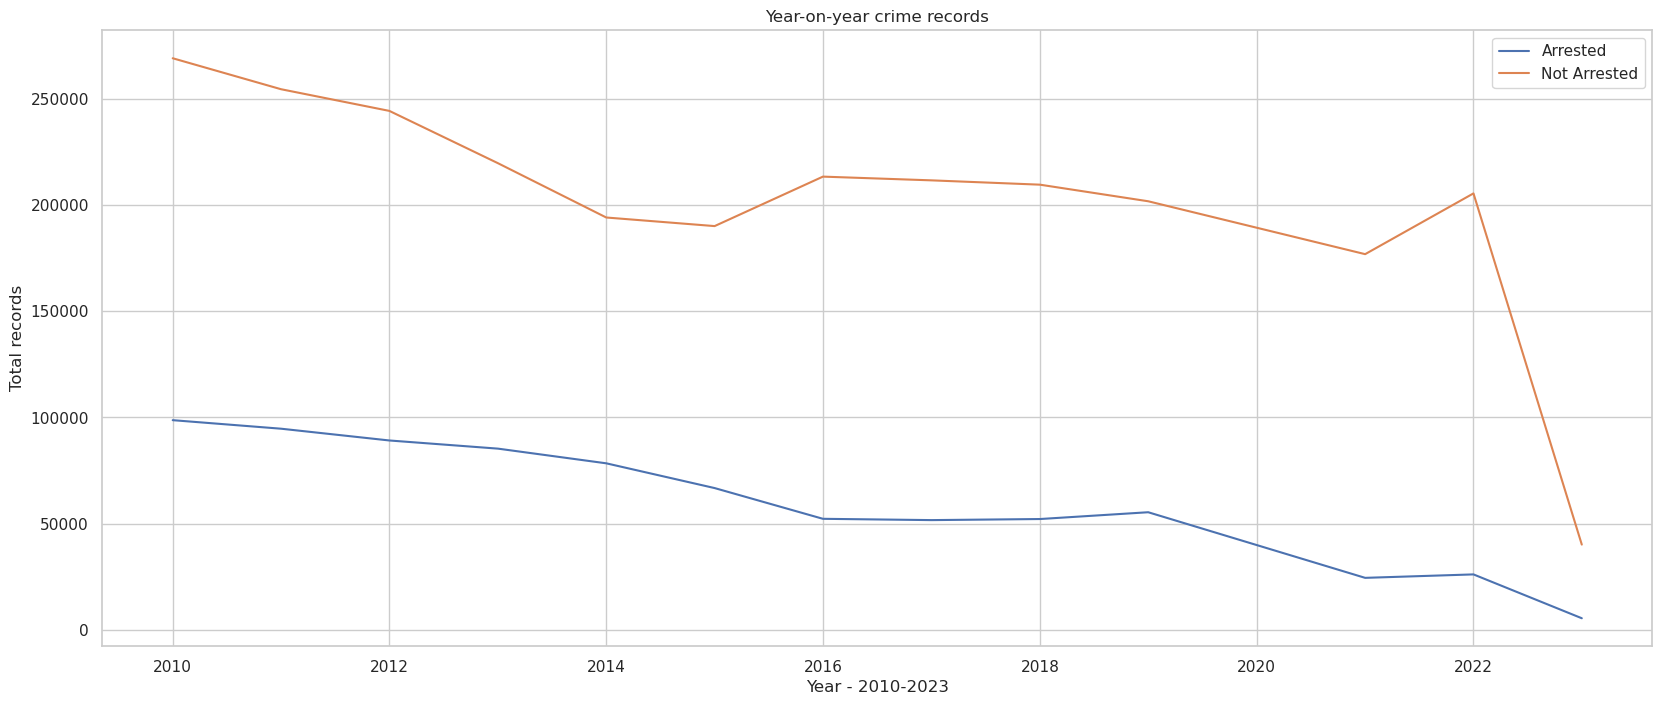

In [33]:
# Data for plotting
t = type_arrest_pddf['count'] - 20 # np.arange(0.0, 2.0, 0.01)
s = type_arrest_pddf['month']

arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == True]
not_arrested = type_arrest_pddf[type_arrest_pddf['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2010-2023', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

It looks like the relative distance between arrests and non-arrests has remained constant..

### What time of the day are criminal the busiest?

In [34]:
df.head(1)

[Row(date='09/05/2015 01:30:00 PM', block='043XX S WOOD ST', primary_type='BATTERY', location_description='RESIDENCE', arrest=False, beat=924, district=9, ward=12, community_area=61, year=2015, latitude=41.815117282, longitude=-87.669999562, month=datetime.date(2015, 1, 1), WeekDay=7, date_time=datetime.datetime(2015, 9, 5, 13, 30))]

In [35]:
# Extract the "hour" field from the date into a separate column called "hour"
print(df['date_time'])
df_hour = df.withColumn('hour', F.hour(df['date_time']))

Column<'date_time'>


In [36]:
df_hour.head(5)

[Row(date='09/05/2015 01:30:00 PM', block='043XX S WOOD ST', primary_type='BATTERY', location_description='RESIDENCE', arrest=False, beat=924, district=9, ward=12, community_area=61, year=2015, latitude=41.815117282, longitude=-87.669999562, month=datetime.date(2015, 1, 1), WeekDay=7, date_time=datetime.datetime(2015, 9, 5, 13, 30), hour=13),
 Row(date='09/04/2015 11:30:00 AM', block='008XX N CENTRAL AVE', primary_type='THEFT', location_description='CTA BUS', arrest=False, beat=1511, district=15, ward=29, community_area=25, year=2015, latitude=41.895080471, longitude=-87.765400451, month=datetime.date(2015, 1, 1), WeekDay=6, date_time=datetime.datetime(2015, 9, 4, 11, 30), hour=11),
 Row(date='09/05/2015 12:45:00 PM', block='035XX W BARRY AVE', primary_type='NARCOTICS', location_description='SIDEWALK', arrest=True, beat=1412, district=14, ward=35, community_area=21, year=2015, latitude=41.937405765, longitude=-87.716649687, month=datetime.date(2015, 1, 1), WeekDay=7, date_time=datetime

In [37]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [38]:
hourly_count_pddf = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count'))\
                                .rdd.map(lambda l: l.asDict())\
                                 .collect())

In [39]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')

Seems that 18-22 are the worst hours...

/tmp/ipykernel_21855/1538506202.py:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both', axis='y')


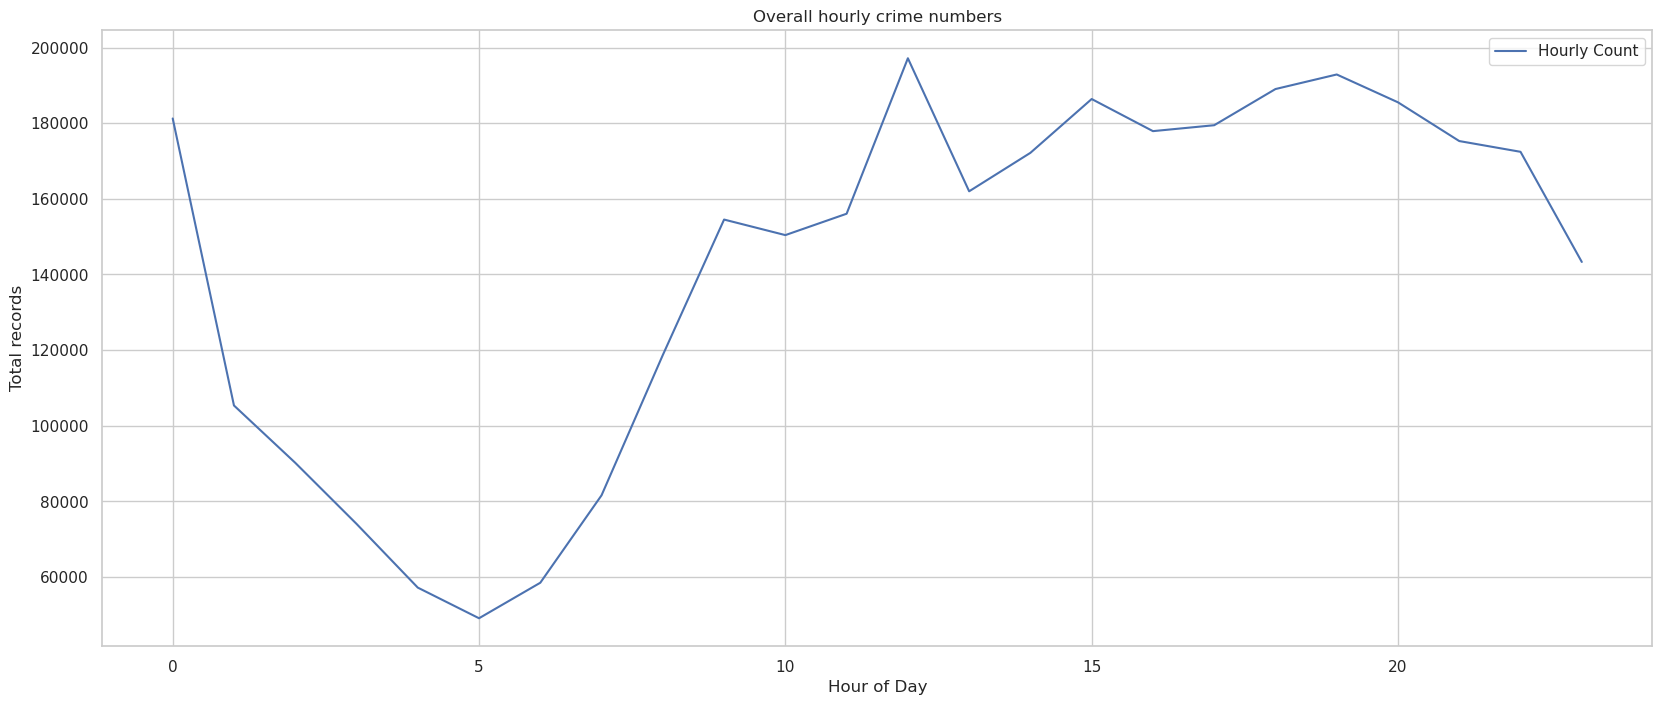

In [40]:
fig, ax = plt.subplots()
ax.plot(hourly_count_pddf['hour'], hourly_count_pddf['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

### Types of locations with crime entries

In [41]:
# Number of types of location recorded in the dataset
df.select('location_description').distinct().count()

202

What are the top 10 places where crime occurred?

In [42]:
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10)

+--------------------+------+
|location_description| count|
+--------------------+------+
|              STREET|810142|
|           RESIDENCE|545268|
|           APARTMENT|465289|
|            SIDEWALK|328388|
|               OTHER|110551|
|PARKING LOT/GARAG...| 85141|
|  SMALL RETAIL STORE| 75180|
|               ALLEY| 73214|
|          RESTAURANT| 65553|
|RESIDENTIAL YARD ...| 58295|
+--------------------+------+
only showing top 10 rows



Can we see how the top crime locations are affected over the day?

In [43]:
#Being on the street and at home
street_home_hour = df.where((df['location_description'] == 'STREET') | (df['location_description'] == 'RESIDENCE'))

In [44]:
street_home_hour

DataFrame[date: string, block: string, primary_type: string, location_description: string, arrest: boolean, beat: int, district: int, ward: int, community_area: int, year: int, latitude: double, longitude: double, month: date, WeekDay: int, date_time: timestamp]

In [45]:
#a data frame with location descriptions and counts of recorded crimes, and hours...
street_home_hour_pddf = pd.DataFrame(street_home_hour.rdd.map(lambda row: row.asDict()).collect())

# 

In [46]:
street_home_hour_pddf.head(5)
# street_home_hour_pddf = street_home_hour_pddf.sort_values(street_home_hour_pddf.date_time)
#street_home_hour_pddf[hour]

,date,block,primary_type,location_description,arrest,beat,district,ward,community_area,year,latitude,longitude,month,WeekDay,date_time
0,09/05/2015 01:30:00 PM,043XX S WOOD ST,BATTERY,RESIDENCE,False,924,9,12,61,2015,41.815117,-87.670000,2015-01-01,7,2015-09-05 13:30:00
1,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,BURGLARY,RESIDENCE,False,614,6,21,71,2015,41.744379,-87.658431,2015-01-01,7,2015-09-05 10:55:00
2,09/05/2015 11:30:00 AM,031XX W WASHINGTON BLVD,ROBBERY,STREET,False,1222,12,27,27,2015,41.882814,-87.704326,2015-01-01,7,2015-09-05 11:30:00
3,09/05/2015 12:50:00 PM,013XX E 47TH ST,BATTERY,STREET,False,222,2,4,39,2015,41.809678,-87.593639,2015-01-01,7,2015-09-05 12:50:00
4,09/03/2015 01:00:00 PM,020XX W SCHILLER ST,THEFT,STREET,False,1424,14,1,24,2015,41.907127,-87.678232,2015-01-01,5,2015-09-03 13:00:00


### A closer look at crime date and time

The information given here indicates when the crime is perpetrated. The date/time field may be able to draw a meaningful trend that can be used to predict crime. However, I believe that this leads much more to external factors, such as policy changes, law inforcement-related factors, and so on.

It's much more likely that time-related features that are more closely relatable to crime occurence be better predictors than the date and time. I mean, knowing the month of the year, the day of the week, and the hour of the day that the crime occurred can enable better chances of predicting accurately than simply knowing "when" AD crimes occurred.

Adding predictors (so far fields) that read time information:

 * hour of day (already added the 'hour' field)
 * day of week
 * month of year
 * day in a range. Instead of using the entire date-time, we'll use a "day sequence" that is counted from 2001-01-01.

In [47]:
df_hour.head(5)

[Row(date='09/05/2015 01:30:00 PM', block='043XX S WOOD ST', primary_type='BATTERY', location_description='RESIDENCE', arrest=False, beat=924, district=9, ward=12, community_area=61, year=2015, latitude=41.815117282, longitude=-87.669999562, month=datetime.date(2015, 1, 1), WeekDay=7, date_time=datetime.datetime(2015, 9, 5, 13, 30), hour=13),
 Row(date='09/04/2015 11:30:00 AM', block='008XX N CENTRAL AVE', primary_type='THEFT', location_description='CTA BUS', arrest=False, beat=1511, district=15, ward=29, community_area=25, year=2015, latitude=41.895080471, longitude=-87.765400451, month=datetime.date(2015, 1, 1), WeekDay=6, date_time=datetime.datetime(2015, 9, 4, 11, 30), hour=11),
 Row(date='09/05/2015 12:45:00 PM', block='035XX W BARRY AVE', primary_type='NARCOTICS', location_description='SIDEWALK', arrest=True, beat=1412, district=14, ward=35, community_area=21, year=2015, latitude=41.937405765, longitude=-87.716649687, month=datetime.date(2015, 1, 1), WeekDay=7, date_time=datetime

In [48]:

df_dates = df_hour.withColumn('week_day', F.dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', F.month(df_hour['date_time']))\
                 .withColumn('month_day', F.dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', F.datediff(df['date_time'], F.to_date(F.lit('2010-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [49]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|09/05/2015 01:30:00 PM|2015-01-01|13  |7       |2015|9         |5        |2073       |
|09/04/2015 11:30:00 AM|2015-01-01|11  |6       |2015|9         |4        |2072       |
|09/05/2015 12:45:00 PM|2015-01-01|12  |7       |2015|9         |5        |2073       |
|09/05/2015 01:00:00 PM|2015-01-01|13  |7       |2015|9         |5        |2073       |
|09/05/2015 10:55:00 AM|2015-01-01|10  |7       |2015|9         |5        |2073       |
|09/04/2015 06:00:00 PM|2015-01-01|18  |6       |2015|9         |4        |2072       |
|09/05/2015 01:00:00 PM|2015-01-01|13  |7       |2015|9         |5        |2073       |
|09/05/2015 11:30:00 AM|2015-01-01|11  |7       |2015|9         |5        |2073       |
|09/05/2015 02:00:00 PM|2015-01-

## Day of week crime levels

It seems intriguing that the're little variance... But bad people are bad all week, aren't they...

In [50]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [51]:
week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

<AxesSubplot:xlabel='week_day', ylabel='count'>

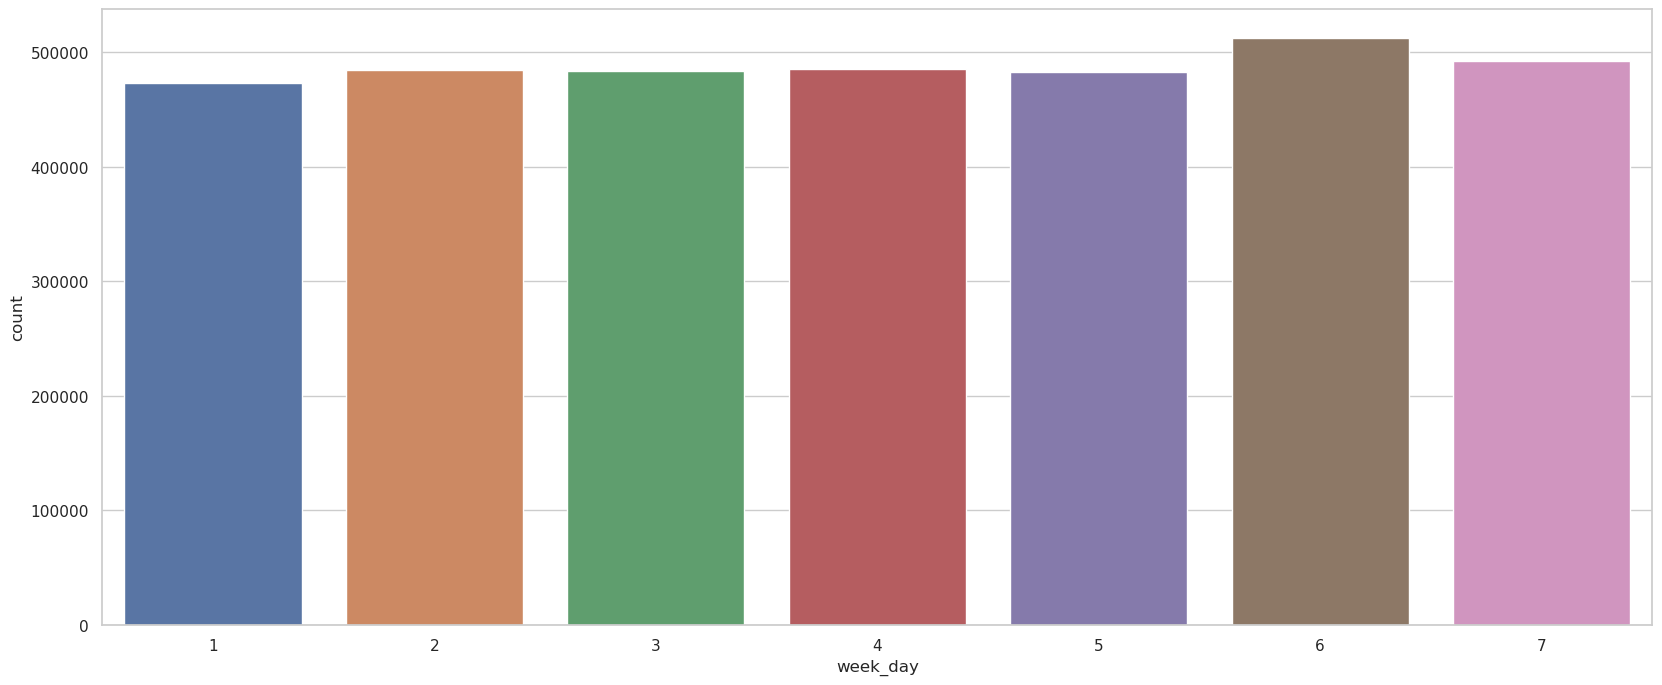

In [52]:
sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

## Month of year

It seems that May-August are the busiest months for criminals... What could be the reason?

In [53]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [54]:
year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

In [55]:
year_month_crime_counts_pddf

,year_month,count
0,1,280111
1,2,243767
2,3,281088
3,4,272930
4,5,300874
5,6,302783
6,7,314590
7,8,311355
8,9,291461
9,10,291787


What happens in MAY through AUGUST?

 * Salary increase season?
 * Weather?

I think these don't form the Christmas season in Chicago...

<AxesSubplot:xlabel='year_month', ylabel='count'>

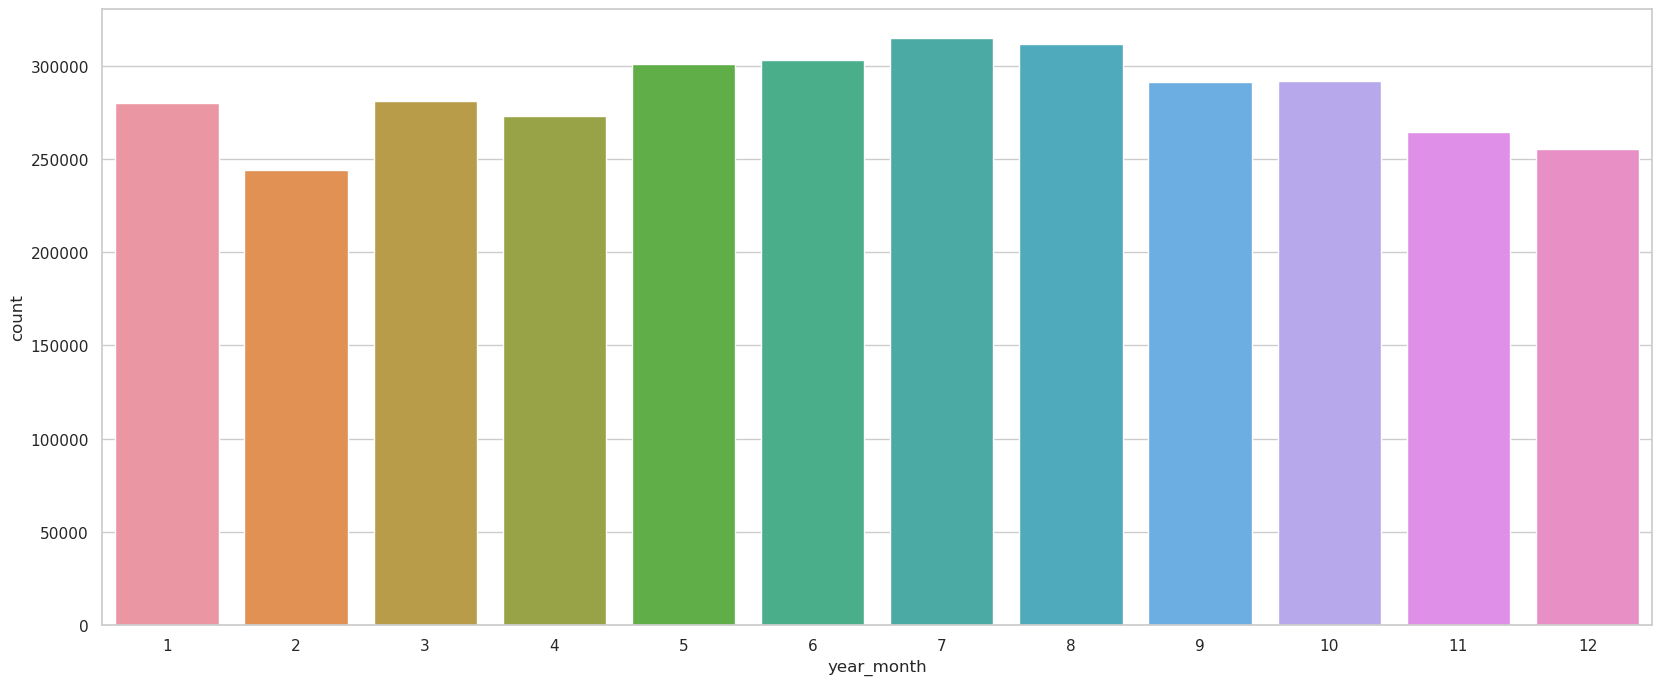

In [56]:
sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

## Day of month

In [57]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

In [58]:
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

#### Top 10 worst days of the month

In [59]:
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,131217
14,15,115281
19,20,112999
16,17,112886
15,16,112389
9,10,112257
22,23,112204
4,5,112019
2,3,111848
18,19,111801


In [60]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

/tmp/ipykernel_21855/2331598223.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='both')


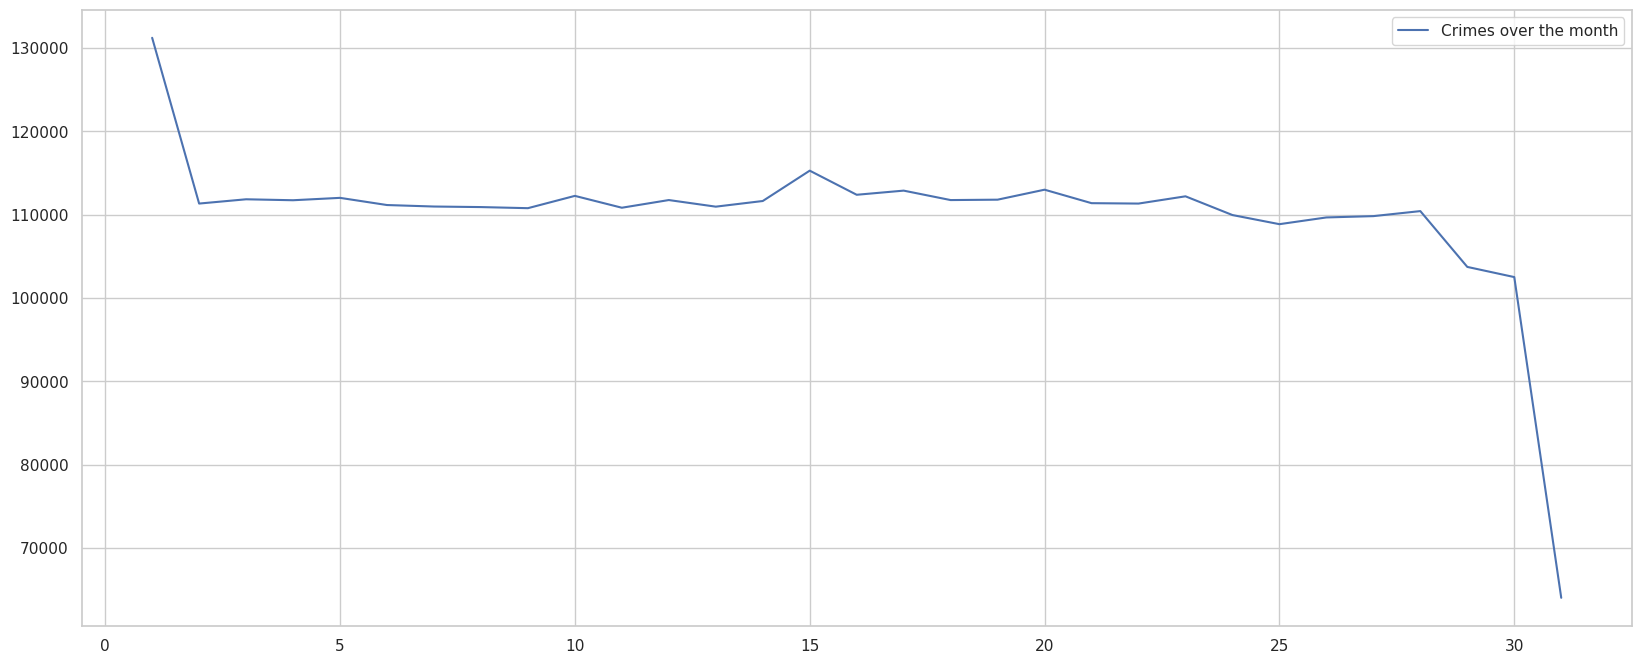

In [61]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

### Community areas?

Chicago has 77 community areas. How do they appear next to one another in a count plot?

In [62]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

What are the to 10 areas with recorded crime?

In [63]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
|community_area| count|
+--------------+------+
|            25|210065|
|             8|129127|
|            43|115499|
|            28|106905|
|            29|106742|
|            23|105797|
|            32|100224|
|            71| 97402|
|            24| 97388|
|            67| 93188|
+--------------+------+
only showing top 10 rows



In [64]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [65]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [66]:
top_crime_types_lst

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'ASSAULT',
 'OTHER OFFENSE',
 'BURGLARY',
 'DECEPTIVE PRACTICE',
 'MOTOR VEHICLE THEFT',
 'ROBBERY']

In [67]:
top_busy_areas_lst

[25, 8, 43, 28, 29, 23, 32, 71, 24, 67]

Find crimes of the top 10 types, that were perpetrated in the 10 10 busiest cities...

In [68]:
q1 = "instr('" + ' '.join(str(area) for area in top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(str(crime_type) for crime_type in top_crime_types_lst) + "', primary_type) > 0"
print(q1)

instr('25 8 43 28 29 23 32 71 24 67', community_area) > 0


In [69]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [70]:
df_dates_tops.count()

1367729

In [71]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [72]:
tops_of_tops.show(20)

+------------+--------------+-----+
|primary_type|community_area|count|
+------------+--------------+-----+
|     ASSAULT|            25|14761|
|     ASSAULT|            43| 9351|
|     ASSAULT|            71| 8093|
|     ASSAULT|            67| 7648|
|     ASSAULT|            29| 7598|
|     ASSAULT|            23| 7348|
|     ASSAULT|            28| 6682|
|     ASSAULT|             8| 5388|
|     ASSAULT|            24| 5057|
|     ASSAULT|            32| 4467|
|     ASSAULT|             1| 3492|
|     ASSAULT|             3| 3301|
|     ASSAULT|             6| 2898|
|     ASSAULT|             2| 2810|
|     ASSAULT|             7| 1612|
|     ASSAULT|             4| 1375|
|     ASSAULT|             5|  773|
|     ASSAULT|             9|  208|
|     BATTERY|            25|43221|
|     BATTERY|            43|25781|
+------------+--------------+-----+
only showing top 20 rows



#### Community area names

Let's link names of these community areas. These float numbers are having a hard time making any sense...

Sourced from Chicago Tribune at http://www.chicagotribune.com/chi-community-areas-htmlstory.html


In [73]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [74]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [75]:
code_pairs[:5]

[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

#### A view of crime count per community area

In [76]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [77]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [78]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

In [79]:
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

,community_area,count,community_area_name
77,0,9,unknown_0
32,9,3408,Edison Park
11,47,4887,Burnside
9,12,6404,Forest Glen
75,74,7506,Mount Greenwood


**What is happening in Austin?**

plt.rcParams["figure.figsize"] = [32, 32]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
area_chart = sns.barplot(x='count', y='community_area_name', data=community_area_counts)
area_chart.set(ylabel="Community Area Name", xlabel="Overall Crimes Record Count")

** *Join these community areas on the main data frame* **

In [80]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [81]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [82]:
named_tops_of_tops.show(10)

+--------------+---------------+------------+-----+
|community_area|      area_name|primary_type|count|
+--------------+---------------+------------+-----+
|            25|         Austin|     ASSAULT|14761|
|            43|    South Shore|     ASSAULT| 9351|
|            71| Auburn Gresham|     ASSAULT| 8093|
|            67| West Englewood|     ASSAULT| 7648|
|            29| North Lawndale|     ASSAULT| 7598|
|            23|  Humboldt Park|     ASSAULT| 7348|
|            28| Near West Side|     ASSAULT| 6682|
|             8|Near North Side|     ASSAULT| 5388|
|            24|      West Town|     ASSAULT| 5057|
|            32|           Loop|     ASSAULT| 4467|
+--------------+---------------+------------+-----+
only showing top 10 rows



In [95]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

<AxesSubplot:xlabel='area_name', ylabel='count'>

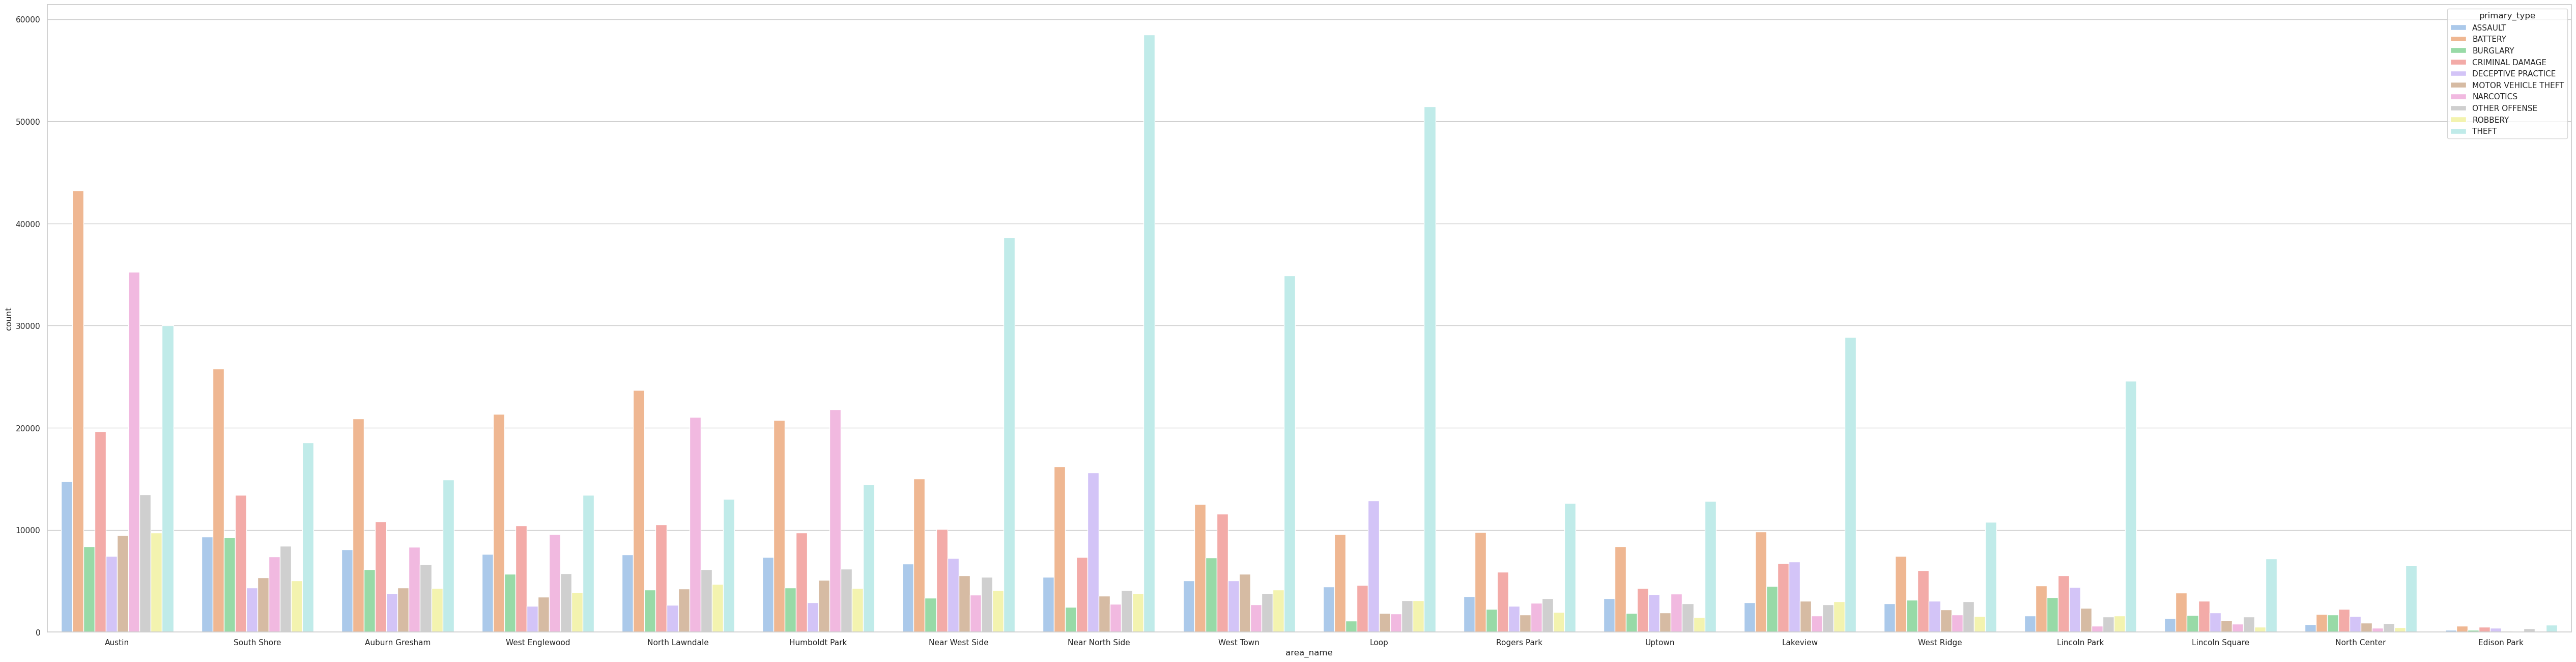

In [96]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')